In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm

# Глобальные параметры визуализаций
plt.rcParams.update({
    "text.usetex": True,       # если установлен LaTeX
    "font.family": "serif",
    "figure.dpi": 110,         # для отображения в ноутбуке
    "figure.autolayout": True,
})

DATA_DIR = Path(".")          # корень проекта (при необходимости поменяйте)
HIST_DIR = DATA_DIR / "model" # там лежат подпапки с history.csv

In [45]:
test_df  = pd.read_csv(DATA_DIR / "test_master.csv")
test_df['accuracy'] = test_df['accuracy'] / 100.0
calib_df = pd.read_csv(DATA_DIR / "calib_master.csv")

# Проверим, какие метрики есть
print("Колонки test_master:", test_df.columns.tolist())
print("Колонки calib_master:", calib_df.columns.tolist())

# Для удобства приведём названия колонок к snake_case
def normalize_cols(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

test_df  = normalize_cols(test_df)
calib_df = normalize_cols(calib_df)

Колонки test_master: ['dataset', 'model', 'loss', 'ls', 'mixup', 'augmix', 'accuracy', 'ece', 'adaece', 'classece', 'brier']
Колонки calib_master: ['dataset', 'model', 'method', 'loss', 'ls', 'mixup', 'augmix', 'accuracy', 'ece', 'adaece', 'classece', 'brier']


In [46]:
histories = []
for csv_path in HIST_DIR.rglob("history.csv"):
    cfg_name = csv_path.parent.name                # имя папки == конфигу
    df = pd.read_csv(csv_path)
    df["config"] = cfg_name
    histories.append(df)

hist_df = pd.concat(histories, ignore_index=True)
hist_df.columns = [c.lower() for c in hist_df.columns]

print("История содержит метрики:", hist_df.columns.tolist()[:10], "...")
print("Всего эпизодов:", hist_df.groupby('config')['epoch'].max().mean().round(1), "эпох.")

История содержит метрики: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_ece', 'val_adaece', 'val_classece', 'val_brier', 'config'] ...
Всего эпизодов: 44.3 эпох.


In [47]:
import re

def build_tag(row) -> str:
    """Создаём tag точно так же, как в run_all.py"""
    aug = "aug" if bool(row["augmix"]) else "noaug"
    return (
        f"{row['dataset']}_{row['model']}_{row['loss']}"
        f"_ls{row['ls']}_mx{row['mixup']}_{aug}"
    )

_num  = r"(?:[0-9]+(?:\.[0-9]+)?)"      # 0, 0.0, 0.2, 10, 10.25 …

PAT = re.compile(
    rf"^(?P<dataset>[^_]+)_"            # cifar10
    rf"(?P<model>[^_]+)_"               # resnet50
    rf"(?P<loss>.+?)_"                  # cross_entropy / dual_focal / bsce_gra
    rf"ls(?P<ls>{_num})_"               # ls0   или ls0.1
    rf"mx(?P<mixup>{_num})_"            # mx0.2
    rf"(?P<augmix>aug|noaug)$"          # aug | noaug
)

def parse_config(tag: str) -> dict:
    m = PAT.match(tag)
    if not m:
        raise ValueError(f"не удалось распарсить tag: {tag}")
    d = m.groupdict()
    d["ls"]     = float(d["ls"])
    d["mixup"]  = float(d["mixup"])
    d["augmix"] = d["augmix"] == "aug"
    return d

def method_group(loss, ls, mixup, augmix) -> str:
    """Правила категоризации (можно подправить под себя)"""
    baseline = (
        (loss == "cross_entropy")
        and ls == 0
        and mixup == 0
        and not augmix
    )
    if baseline:
        return "Baseline"

    parts = []
    if loss != "cross_entropy":
        parts.append("AltLoss")
    if (ls > 0) or (mixup > 0) or augmix:
        parts.append("RegAug")
    return "+".join(parts)


# ---------- 2. Строим/парсим config ---------- #

# test_df & calib_df: создаём столбец config, если его ещё нет
for df in (test_df, calib_df):
    if "config" not in df.columns:
        df["config"] = df.apply(build_tag, axis=1)

# hist_df: парсим существующий config
parsed = pd.DataFrame(hist_df["config"].apply(parse_config).tolist())
hist_df = pd.concat([hist_df, parsed], axis=1)

# ---------- 3. Проставляем method ---------- #

# для test_df
test_df["method"] = test_df.apply(
    lambda r: method_group(r["loss"], r["ls"], r["mixup"], r["augmix"]), axis=1
)

# для calib_df — это всегда Post-hoc (тип калибратора в столбце method сохраняем отдельно)
calib_df["method_group"] = "Post-hoc"          # новая колонка-группа
calib_df.rename(columns={"method": "calibrator"}, inplace=True)

# для hist_df
hist_df["method"] = hist_df.apply(
    lambda r: method_group(r["loss"], r["ls"], r["mixup"], r["augmix"]), axis=1
)

# ---------- 4. Быстрая проверка ---------- #
print("test_df:", test_df["method"].value_counts(), sep="\n")
print("\ncalib_df (группы):", calib_df["method_group"].value_counts(), sep="\n")
print("\nhist_df:", hist_df["method"].value_counts(), sep="\n")


test_df:
method
AltLoss+RegAug    27
RegAug             9
AltLoss            9
Baseline           3
Name: count, dtype: int64

calib_df (группы):
method_group
Post-hoc    192
Name: count, dtype: int64

hist_df:
method
AltLoss+RegAug    1289
AltLoss            425
RegAug             361
Baseline           100
Name: count, dtype: int64


In [48]:
calib_df

,dataset,model,calibrator,loss,ls,mixup,augmix,accuracy,ece,adaece,classece,brier,config,method_group
0,cifar10,resnet50,temperature,cross_entropy,0.0,0.0,False,0.683600,0.034375,0.034184,0.594641,0.429205,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc
1,cifar10,resnet50,platt,cross_entropy,0.0,0.0,False,0.720600,0.029127,0.025642,0.632994,0.384747,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc
2,cifar10,resnet50,isotonic,cross_entropy,0.0,0.0,False,0.702200,0.022916,0.025897,0.622615,0.407810,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc
3,cifar10,resnet50,bbq,cross_entropy,0.0,0.0,False,0.159800,0.020206,0.023617,0.384240,0.883886,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc
4,cifar10,resnet50,temperature,cross_entropy,0.1,0.0,False,0.765200,0.030224,0.028392,0.658983,0.330110,cifar10_resnet50_cross_entropy_ls0.1_mx0.0_noaug,Post-hoc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,otto,mlp,bbq,bsce_gra,0.0,0.2,False,0.382353,0.014791,0.041674,0.360558,0.757891,otto_mlp_bsce_gra_ls0.0_mx0.2_noaug,Post-hoc
188,otto,mlp,temperature,bsce_gra,0.0,0.0,True,0.773756,0.075490,0.073216,0.597947,0.316455,otto_mlp_bsce_gra_ls0.0_mx0.0_aug,Post-hoc
189,otto,mlp,platt,bsce_gra,0.0,0.0,True,0.779250,0.022734,0.026722,0.646625,0.291892,otto_mlp_bsce_gra_ls0.0_mx0.0_aug,Post-hoc
190,otto,mlp,isotonic,bsce_gra,0.0,0.0,True,0.780866,0.030340,0.030293,0.620748,0.301221,otto_mlp_bsce_gra_ls0.0_mx0.0_aug,Post-hoc


In [49]:
def smooth(y, window=3):
    return y.rolling(window, center=True, min_periods=1).mean()

def plot_metric(metric: str,
                df: pd.DataFrame,
                group: str = "config",
                color_by: str = "method",
                smooth_window: int = 1,
                max_epoch: int | None = None):
    """
    Рисуем кривые <metric> по эпохам.
      • <group>   — что считаем «отдельной кривой» (обычно config)
      • <color_by>— чем окрашиваем (обычно method)
    """
    # цветовая палитра по значениям color_by
    unique_vals = df[color_by].unique()
    palette = dict(zip(unique_vals,
                       sns.color_palette("tab10", n_colors=len(unique_vals))))

    plt.figure(figsize=(7, 4))

    for name, sub in df.groupby(group):
        clr_key = sub[color_by].iloc[0]
        x = sub["epoch"]
        y = sub[metric]
        if smooth_window > 1:
            y = y.rolling(smooth_window, center=True,
                          min_periods=1).mean()
        if max_epoch is not None:
            mask = x <= max_epoch
            x, y = x[mask], y[mask]

        plt.plot(x, y, color=palette[clr_key],
                 linewidth=1.2, alpha=.9,
                 label=name)

    # Оформление
    plt.title(f"{metric} vs. epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(alpha=.3)
    # Легенда справа, мелким шрифтом
    plt.legend(bbox_to_anchor=(1.05, 1),
               loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1036829/430477134.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


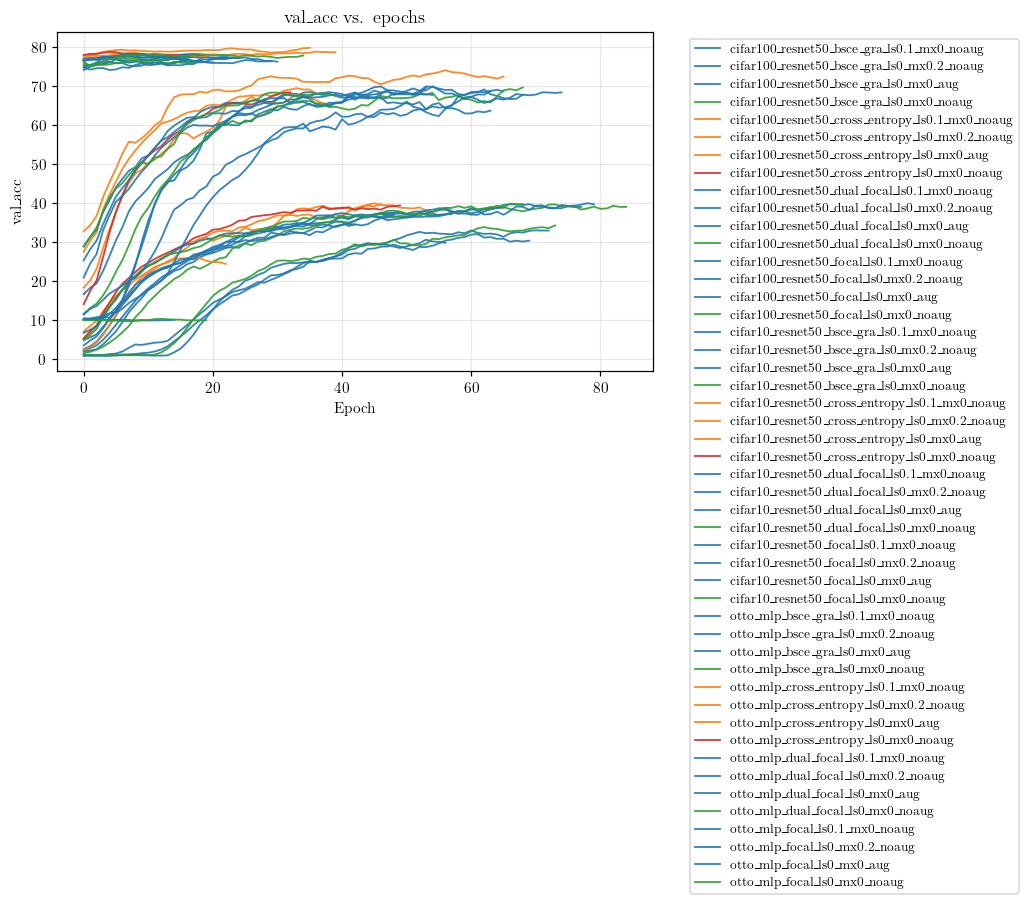

/tmp/ipykernel_1036829/430477134.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


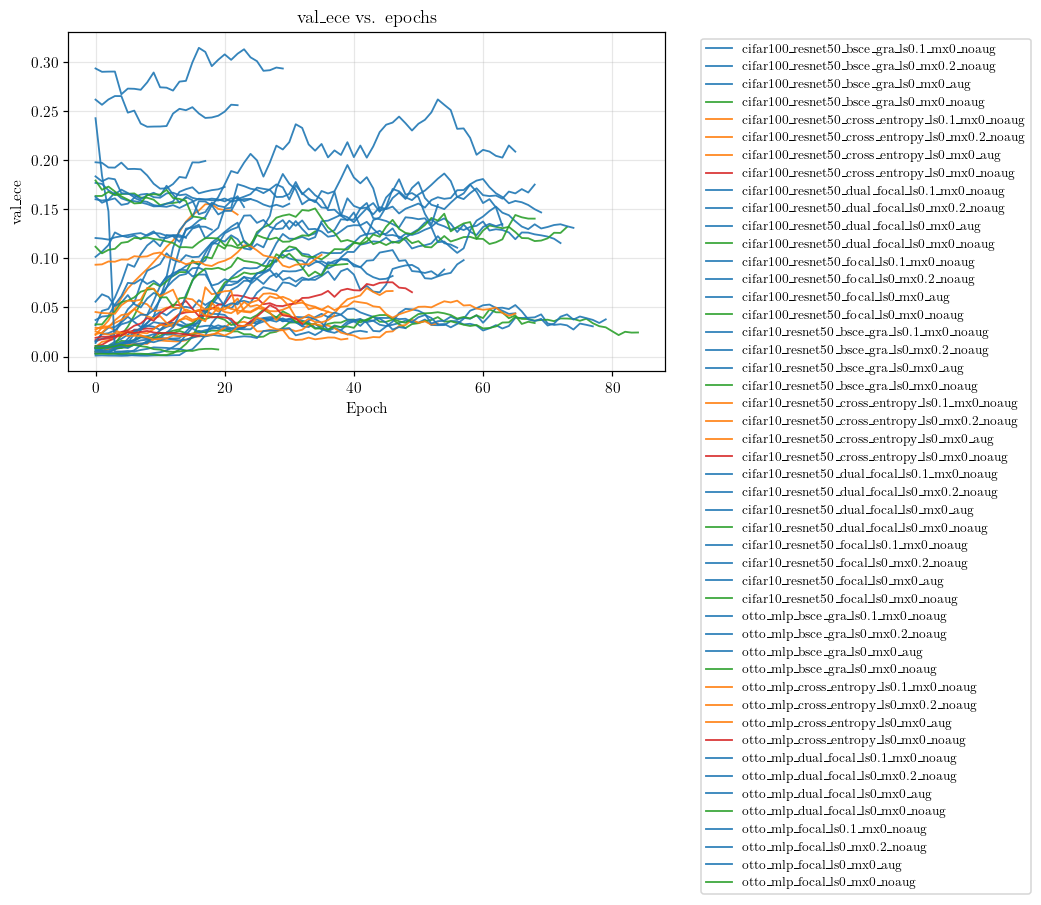

In [50]:
plot_metric("val_acc", hist_df, smooth_window=5)
plot_metric("val_ece", hist_df, smooth_window=5)

In [64]:
# ────────── utils_plot.py ──────────
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional, Iterable

OUT_DIR = Path("figures")
OUT_DIR.mkdir(exist_ok=True, parents=True)

def plot_metric_ds(
    df: pd.DataFrame,
    metric: str,
    datasets: Optional[Iterable[str]] = None,
    hue: str = "method",
    smooth_window: int = 1,
    max_epoch: Optional[int] = None,
    save_pdf: bool = True,
    show_legend: bool = True,
):
    """
    Рисует кривые <metric> по эпохам отдельно для каждого датасета.

    Parameters
    ----------
    df : DataFrame  — hist_df с колонками epoch, metric, dataset, <hue>
    metric : str    — имя столбца для оси Y (например 'val_acc')
    datasets : list — какие датасеты рисовать (None → все)
    hue : str       — чем раскрашивать кривые (обычно 'method')
    smooth_window : int  — ширина скользящего среднего
    max_epoch : int — обрезать график
    save_pdf : bool — сохранять ли PDF+SVG
    """
    if datasets is None:
        datasets = df["dataset"].unique()

    palette = sns.color_palette("tab10", n_colors=df[hue].nunique())

    for ds in datasets:
        sub_ds = df[df["dataset"] == ds]
        if sub_ds.empty:
            continue

        plt.figure(figsize=(6, 4))
        for name, run in sub_ds.groupby("config"):
            x = run["epoch"]
            y = run[metric]
            if smooth_window > 1:
                y = y.rolling(smooth_window, center=True,
                              min_periods=1).mean()
            if max_epoch is not None:
                m = x <= max_epoch
                x, y = x[m], y[m]
            col = palette[sub_ds[hue].cat.codes.loc[run.index[0]]]
            plt.plot(x, y, color=col, alpha=.85, linewidth=1)

        plt.title(f"{ds}: {metric} vs. epochs")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        if show_legend:
            handles, labels = [], []
            for m, col in zip(sub_ds[hue].cat.categories, palette):
                handles.append(plt.Line2D([], [], color=col, lw=3))
                labels.append(m)
            plt.legend(handles, labels, title=hue, bbox_to_anchor=(1.04, 1),
                       loc="upper left", fontsize="small")
        plt.grid(alpha=.3)
        plt.tight_layout()

        if save_pdf:
            base = f"{ds}_{metric}"
            plt.savefig(OUT_DIR / f"{base}.pdf",  bbox_inches="tight")
            plt.savefig(OUT_DIR / f"{base}.svg",  bbox_inches="tight")
        plt.show()


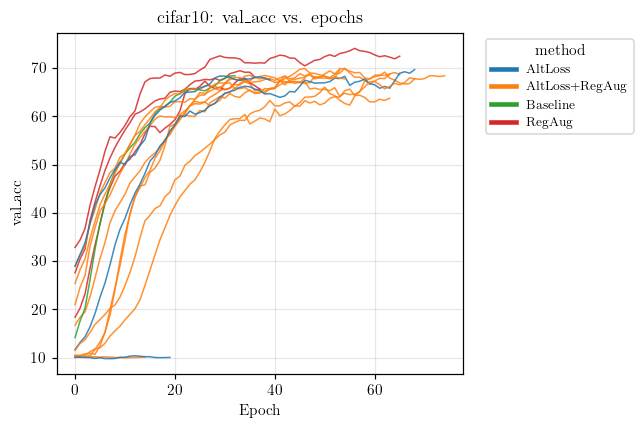

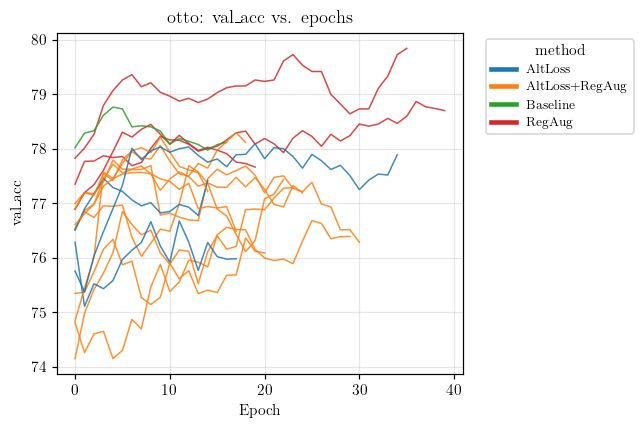

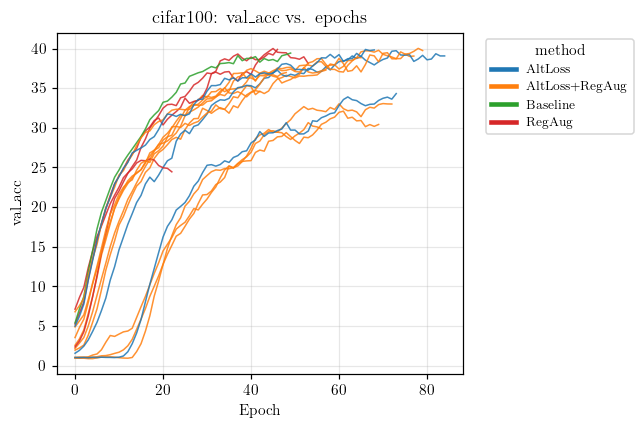

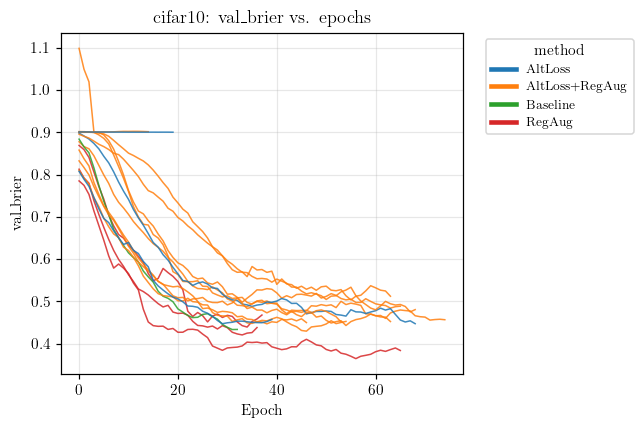

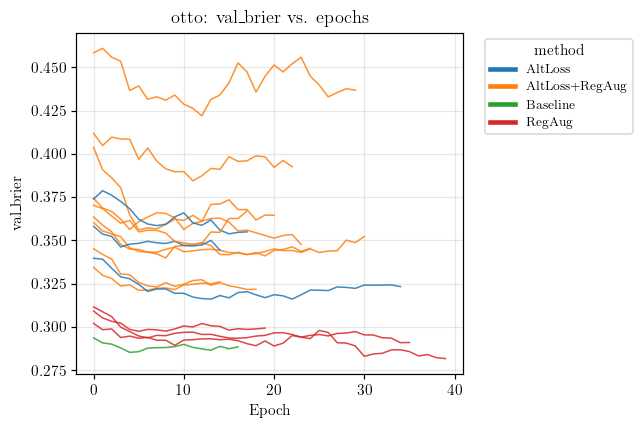

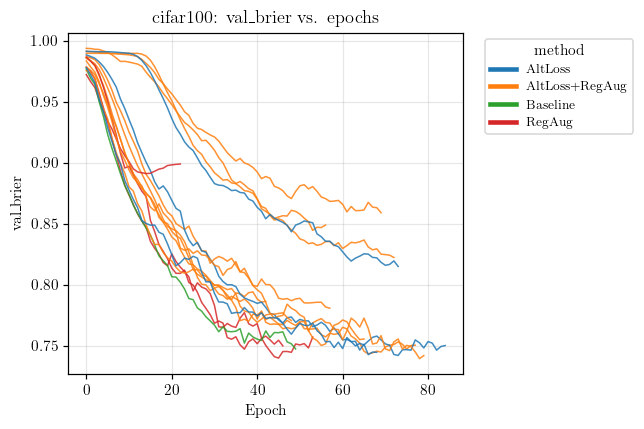

In [66]:
# предварительно убедитесь, что hist_df['dataset'] и hist_df['method'] — категориальные
hist_df["dataset"] = hist_df["dataset"].astype("category")
hist_df["method"]  = hist_df["method"].astype("category")

plot_metric_ds(hist_df, metric="val_acc",  smooth_window=5)
plot_metric_ds(hist_df, metric="val_brier", smooth_window=5, max_epoch=100)

In [51]:

final_cols = ["config", "method", "accuracy", "brier"]

base_table  = test_df[final_cols].copy().rename(
    columns={"accuracy": "acc_raw", "brier": "bs_raw"}
)

calib_cols = ["config", "accuracy", "brier"]
calib_cols = [c for c in calib_cols if c in calib_df.columns]
calib_table = calib_df[calib_cols].copy().rename(
    columns={"accuracy": "acc_calib", "brier": "bs_calib"}
)

merged = base_table.merge(calib_table, on="config", how="left")

# Вычислим разницу «до/после»
merged["bs_delta"]  = merged["bs_raw"]  - merged["bs_calib"]
merged["acc_delta"] = merged["acc_calib"] - merged["acc_raw"]

# Выведем LaTeX-таблицу
latex_table = merged.groupby("method")[[
    "acc_raw", "acc_calib", "bs_raw", "bs_calib"
]].mean().round(4).to_latex(float_format="%.4f")

print(latex_table)


\begin{tabular}{lrrrr}
\toprule
 & acc_raw & acc_calib & bs_raw & bs_calib \\
method &  &  &  &  \\
\midrule
AltLoss & 0.5689 & 0.4804 & 0.5484 & 0.6081 \\
AltLoss+RegAug & 0.6053 & 0.5099 & 0.5301 & 0.5883 \\
Baseline & 0.6379 & 0.5357 & 0.4715 & 0.5637 \\
RegAug & 0.6322 & 0.5296 & 0.4756 & 0.5828 \\
\bottomrule
\end{tabular}



In [56]:
merged

,config,method,acc_raw,bs_raw,acc_calib,bs_calib,bs_delta,acc_delta
0,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Baseline,0.683600,0.429341,0.683600,0.429205,0.000136,-8.487701e-09
1,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Baseline,0.683600,0.429341,0.720600,0.384747,0.044595,3.699999e-02
2,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Baseline,0.683600,0.429341,0.702200,0.407810,0.021531,1.859999e-02
3,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Baseline,0.683600,0.429341,0.159800,0.883886,-0.454544,-5.238000e-01
4,cifar10_resnet50_cross_entropy_ls0.1_mx0.0_noaug,RegAug,0.765200,0.332636,0.765200,0.330110,0.002526,-1.888275e-08
...,...,...,...,...,...,...,...,...
187,otto_mlp_bsce_gra_ls0.0_mx0.2_noaug,AltLoss+RegAug,0.764383,0.379418,0.382353,0.757891,-0.378473,-3.820297e-01
188,otto_mlp_bsce_gra_ls0.0_mx0.0_aug,AltLoss+RegAug,0.773756,0.347966,0.773756,0.316455,0.031512,-1.348521e-08
189,otto_mlp_bsce_gra_ls0.0_mx0.0_aug,AltLoss+RegAug,0.773756,0.347966,0.779250,0.291892,0.056075,5.494492e-03
190,otto_mlp_bsce_gra_ls0.0_mx0.0_aug,AltLoss+RegAug,0.773756,0.347966,0.780866,0.301221,0.046746,7.110523e-03


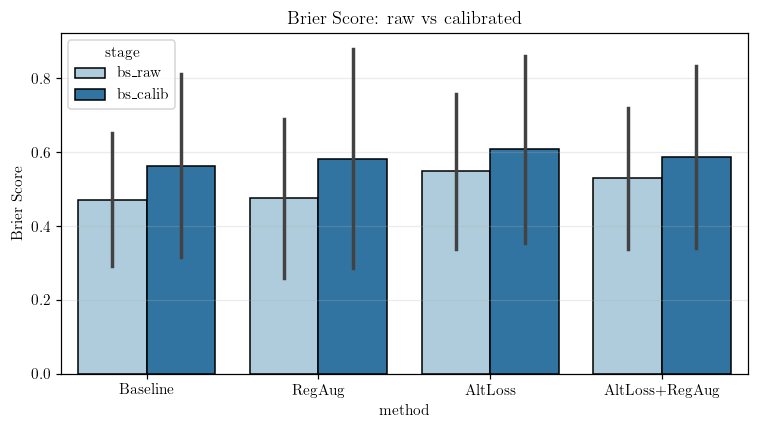

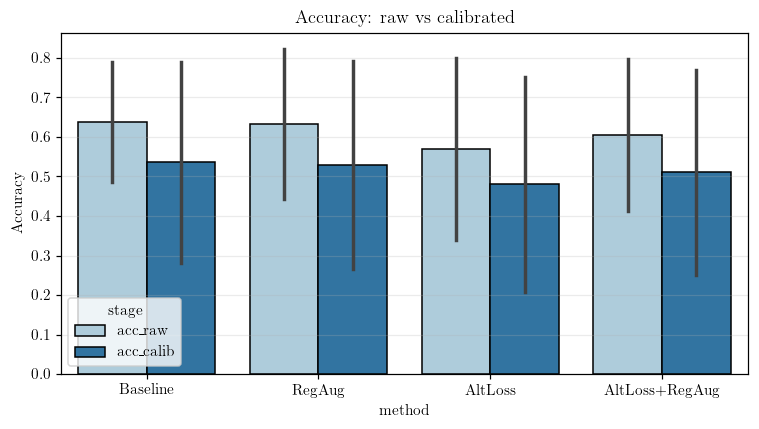

In [62]:
# ⬇️ ЯЧЕЙКА 7 – новая версия
def bar_compare(metric_raw: str,
                metric_cal: str,
                y_label: str,
                title: str):
    """
    Столбчатая диаграмма «сырое vs калиброванное» для одной метрики.
      metric_raw — имя колонки с исходным значением
      metric_cal — имя колонки после калибровки
      y_label     текст на оси Y
    """
    # Проверим, что оба столбца действительно есть
    missing = [c for c in (metric_raw, metric_cal) if c not in merged.columns]
    if missing:
        raise KeyError(f"В merged нет колонок: {missing}")

    df_plot = merged.melt(
        id_vars=["config", "method"],
        value_vars=[metric_raw, metric_cal],
        var_name="stage",
        value_name="value"          # ← не конфликтует с существующими
    )

    plt.figure(figsize=(7, 4))
    sns.barplot(
        data=df_plot,
        x="method",
        y="value",
        hue="stage",
        palette="Paired",
        edgecolor="black",
        errorbar="sd"
    )

    plt.title(title)
    plt.ylabel(y_label)
    plt.grid(axis="y", alpha=.25)
    plt.tight_layout()

    f_name = f"fig_{metric_raw.split('_')[0]}_bar.pdf"
    plt.savefig(f_name, bbox_inches="tight")
    plt.savefig(f_name.replace(".pdf", ".svg"), bbox_inches="tight")
    plt.show()


# --- вызовы ---------------------------------------------------------------
bar_compare("bs_raw",  "bs_calib",
            y_label="Brier Score",
            title="Brier Score: raw vs calibrated")

bar_compare("acc_raw", "acc_calib",
            y_label="Accuracy",
            title="Accuracy: raw vs calibrated")


In [63]:
import torch
torch.__version__

'2.3.0+cu121'